# LGBM - Training

Sources
1. [LGBM & Deberta Explained by ZULQARNAIN ALI](https://www.kaggle.com/code/zulqarnainalipk/lgbm-deberta-explained)

## Setup

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
import lightgbm as lgb
import pickle as pkl
import wandb
from lightgbm import log_evaluation, early_stopping
from sklearn.model_selection import StratifiedGroupKFold
import matplotlib.pyplot as plt

In [2]:
os.chdir("../../")

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.utils.utils import seed_everything
from lib.criterion.metrics import log_metrics
from lib.model.utils import quadratic_weighted_kappa, qwk_obj, get_score
from lib.utils.find_threshold import find_thresholds

In [4]:
seed_everything()

### Setting Up WandB

In [5]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
WANDB_NAME = f"LGBM-ASE-17H"

In [6]:
wandb.login(key=os.environ.get('WANDB_API_KEY'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
    config=config,
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


## Model Training

### Dataset Creation

In [7]:
df = pd.read_csv(Paths.TRAIN_CSV_PATH, usecols=["score", "topic"])
X = pd.read_csv(Paths.FEATURE_ENGG_CSV_PATH)
ids, X = X.loc[:, "essay_id"], X.drop(columns=["essay_id"])
topic, y = df.loc[:, "topic"], df.loc[:, "score"]

del df
X.shape, y.shape

((17307, 104), (17307,))

### Callbacks

In [8]:
callbacks = [
    # log_evaluation(period=25),
    early_stopping(stopping_rounds=75, first_metric_only=True),
]

### Constants

In [9]:
a = config.lgbm_a
b = config.lgbm_b

### Training Loop

In [10]:
def train_loop(X_train, y_train, X_valid, y_valid):
    y_train = y_train.astype(np.float32) - a
    y_valid = y_valid.astype(np.float32) - a

    model = lgb.LGBMRegressor(
        objective=qwk_obj,
        metrics="None",
        learning_rate=0.05455,
        max_depth=5,
        num_leaves=15,
        colsample_bytree=0.8842,
        reg_alpha=0.5637,
        reg_lambda=0.6781,
        n_estimators=1896,
        random_state=config.random_seed,
        extra_trees=True,
        class_weight="balanced",
        n_jobs=6,
        verbosity=0,
    )

    # Train model
    predictor = model.fit(
        X_train,
        y_train,
        eval_names=["train", "valid"],
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_metric=quadratic_weighted_kappa,
        callbacks=callbacks,
    )

    return model, predictor

In [11]:
def validate_model(idx, X_valid, y_valid, id_valid, predictor):
    y_valid_int = y_valid.astype(np.int64).to_numpy()
    preds_raw = predictor.predict(X_valid) + a
    preds = preds_raw.clip(1, 6).round().astype(np.int64)

    oof = pd.DataFrame(
        {
            "essay_id": id_valid,
            "score": y_valid_int - 1,
            "pred_score": preds - 1,
            "raw": preds_raw
        }
    )
    log_metrics(oof, f"Fold {idx}")

    return oof

### Fold Loop

In [12]:
skf = StratifiedGroupKFold(
    n_splits=config.lgbm_n_folds,
    random_state=config.random_seed,
    shuffle=True,
)

In [13]:
oof_df = pd.DataFrame()

for idx, (train_idx, valid_idx) in enumerate(skf.split(X, y, groups=topic)):
    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_valid, y_valid = X.loc[valid_idx], y.loc[valid_idx]
    id_valid = ids.loc[valid_idx].to_numpy()

    model, predictor = train_loop(X_train, y_train, X_valid, y_valid)

    with open(f"output/LGBM/{idx}.pkl", "wb") as file:
        pkl.dump({"predictor": predictor, "model": model}, file)

    oof = validate_model(idx, X_valid, y_valid, id_valid, predictor)
    oof_df = pd.concat([oof_df, oof])

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[108]	train's QWK: 0.807209	valid's QWK: 0.805246
Evaluated only: QWK
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/media/ishfar/New Volume/Studies/Projects/Kaggle-Automated-Essay-Scoring/lib/criterion/metrics.py:34: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
/media/ishfar/New Volume/Studies/Projects/Kaggle-Automated-Essay-Scoring/lib/criterion/metrics.py:35: RuntimeWarning: invalid value encountered in scalar divide
  recall = tp / (tp + fn)


[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[105]	train's QWK: 0.807862	valid's QWK: 0.786008
Evaluated only: QWK
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[39]	train's QWK: 0.79545	valid's QWK: 0.702644
Evaluated only: QWK


/media/ishfar/New Volume/Studies/Projects/Kaggle-Automated-Essay-Scoring/lib/criterion/metrics.py:34: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[338]	train's QWK: 0.827765	valid's QWK: 0.798948
Evaluated only: QWK


In [14]:
score = get_score(oof_df["score"], oof_df["pred_score"])
print(f'QWK score before thresholding: {score:<.4f}')
wandb.log({"CV/qwk_score": score})

QWK score before thresholding: 0.7915


In [15]:
wandb.log({"oof_table": wandb.Table(dataframe=oof_df)})

In [16]:
oof_df.to_csv("output/oof.csv", index=False)

In [17]:
log_metrics(
    pd.DataFrame(
        {
            "score": oof_df.score.to_numpy(),
            "pred_score": oof_df.pred_score.to_numpy(),
        }
    ),
    "Overall",
)

### Finding Optimal Thresholds

In [18]:
best, threshold, xs, ys = find_thresholds(oof_df["score"] + 1, oof_df["raw"], steps=500)

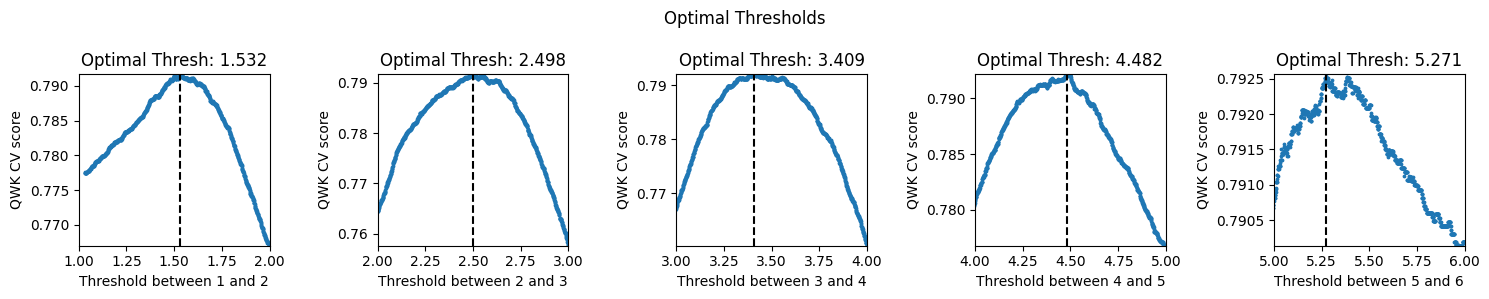

In [19]:
diff = 0.5
nrows, ncols = 1, 5  # Define grid for 5 subplots (1 row, 5 columns)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3))  # Create figure and subplots

# Loop through data and plot on each subplot
for k in range(5):
    ax = axes.flat[k]  # Access each subplot using flattened axes
    ax.scatter(xs[k], ys[k], s=3)
    m = k + 1.5
    ax.set_xlim((m - diff, m + diff))
    i = np.where((np.array(xs[k]) > m - diff) & (np.array(xs[k]) < m + diff))[0]
    mn = np.min(np.array(ys[k])[i])
    mx = np.max(np.array(ys[k])[i])
    ax.set_ylim((mn, mx))

    ax.plot(
        [threshold[k], threshold[k]],
        [mn, mx],
        "--",
        color="black",
        label="optimal threshold",
    )

    ax.set_title(f"Optimal Thresh: {threshold[k]:4.3f}", size=12)  # Adjust title size
    ax.set_xlabel(f"Threshold between {k+1} and {k+2}", size=10)
    ax.set_ylabel("QWK CV score", size=10)

# Common legend for all subplots
plt.suptitle("Optimal Thresholds", size=12)
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [20]:
with open("output/LGBM/threshold.pkl", "wb") as file:
    pkl.dump(threshold, file)

In [21]:
def raw_to_class(pred, threshold):
    return pd.cut(
        pred,
        [-np.inf] + threshold + [np.inf],
        labels=range(6),
    ).astype(pd.Int32Dtype())

In [22]:
score = get_score(oof_df["score"], raw_to_class(oof_df["raw"], threshold))
print(f"QWK score after thresholding: {score}")
wandb.log({"CV/qwk_score_after_threshold": score})

QWK score after thresholding: 0.7925615702926835


In [23]:
wandb.finish()

CV/qwk_score,▁
CV/qwk_score_after_threshold,▁
CV/qwk_score,0.79147
CV/qwk_score_after_threshold,0.79256
